In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
train = pd.read_csv('./data/train.csv',index_col='index')
train.head()

/home/frodos/anaconda/lib/python2.7/site-packages/numpy/lib/arraysetops.py:395: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,event_id,X,Y,Z,TX,TY,chi2,signal,brick_number
index,,,,,,,,,
0,-999,66162.843750,65620.031250,0.0,0.166890,0.276674,2.988714,0.0,44
1,-999,43900.445312,67091.671875,0.0,-0.179967,-0.478795,1.901420,0.0,98
2,-999,37564.019531,26618.890625,55599.0,-0.267820,-0.282087,2.510245,0.0,64
3,-999,39380.027344,48135.425781,19395.0,0.265197,-0.577493,1.215219,0.0,63
4,-999,65040.781250,44018.468750,12930.0,-0.711161,-0.245592,2.973661,0.0,2


In [4]:
%%time
def getTracks(layer0,layer1,dx,dy,dtx,dty,dz):
    '''
    layer0, layer1 - Pandas dataframe with track parameters
    dx, dy, dtx, dty - errors of parameters
    dz - distance between layer1 and layer0
    '''

    layer0Arr = layer0.reset_index().as_matrix(columns = ['index', 'X', 'Y', 'TX', 'TY', 'signal'])
    layer1Arr = layer1.sort_values(by='X',ascending=True).reset_index().as_matrix(columns = ['index', 'X', 'Y', 'TX', 'TY', 'signal'])

    res = np.empty([0,10])
    for track in layer0Arr:
        #calculate new pos
        newX  = track[1]+dz*np.tan(track[3])
        newY  = track[2]+dz*np.tan(track[4])
        newTX = track[3]
        newTY = track[4]

        #print 
        lEdge = np.searchsorted(layer1Arr[:,1],newX-dx,side='left')
        rEdge = np.searchsorted(layer1Arr[:,1],newX+dx,side='right')
        subSet = layer1Arr[lEdge:rEdge,:]
        subSet = subSet[np.where((subSet[:,2]>newY-dy) &  (subSet[:,2]<newY+dy) & (subSet[:,3]>newTX-dtx) & (subSet[:,3]<newTX+dtx) & (subSet[:,4]>newTY-dty) & (subSet[:,4]<newTY+dty)),:][0]

        if subSet.shape[0] > 0:
            #print subSet
            r = np.sqrt(np.power(subSet[:,1]-newX,2)+np.power(subSet[:,2]-newY,2))
            da = subSet[:,3]-newTX
            db = subSet[:,4]-newTY
            subSet = np.hstack((subSet,np.expand_dims(r,1),np.expand_dims(da,1),np.expand_dims(db,1),track[0]*np.ones([db.shape[0],1])))
            res = np.vstack((res,subSet))

    return res        

CPU times: user 0 ns, sys: 0 ns, total: 0 ns
Wall time: 5.96 µs


In [5]:
finalArr = np.ones([0,10])

dx  = 100 # estimation of error along OX axis
dy  = 100 # estimation of error along OY axis
dtx = 0.2
dty = 0.2

for brickId, brick in train.groupby('brick_number'):

    # create dictionaries
    zPos = np.sort(brick.Z.unique())
    zPosDict = dict(enumerate(zPos)) # dictionary of positions (layerNumber => position)
    zDiffDict = dict(enumerate(np.diff(zPos))) # dictionaru of distances (layerNumber => distance to the next layer)
    layerDict = {v: k for k, v in zPosDict.iteritems() } # dictionary of layer number (position => layerNumber)

    # add extra feature - layer number
    brick = brick.assign(layerId = brick.Z.map(layerDict))


    ## name of colums
    cols = ['index', 'X', 'Y', 'TX', 'TY', 'signal', 'r', 'da', 'db', 'parent']

    for layerId in np.sort(brick.layerId.unique())[0:-1]:
        dz = zDiffDict.get(layerId)

        layer0 = brick.query('layerId == @layerId')
        layer1 = brick.query('layerId == @layerId+1')
        arr = getTracks(layer0,layer1,dx,dy,dtx,dty,dz)
        finalArr = np.vstack([finalArr,arr])
        
fdf = pd.DataFrame(finalArr,columns=cols)
print 'Done'

Done


In [6]:
fdf = pd.DataFrame(finalArr,columns=cols)
fdf.set_index('index',inplace=True)
fdf.head()

,X,Y,TX,TY,signal,r,da,db,parent
index,,,,,,,,,
892028.0,65944.695312,66873.703125,0.372805,-0.018341,0.0,127.594544,-0.076972,-0.194308,3367701.0
774883.0,30086.503906,56736.628906,-0.327097,0.077269,0.0,94.477411,0.090072,-0.005022,9314219.0
2741636.0,54708.191406,47517.656250,-0.234412,0.192783,0.0,93.918329,-0.003832,-0.068173,129033.0
5107504.0,36029.890625,37156.414062,-0.024786,0.337202,0.0,46.648367,0.117150,0.098270,4425962.0
9250117.0,66673.132812,41541.593750,0.182478,-0.260138,0.0,11.381803,0.015811,0.188095,7066409.0


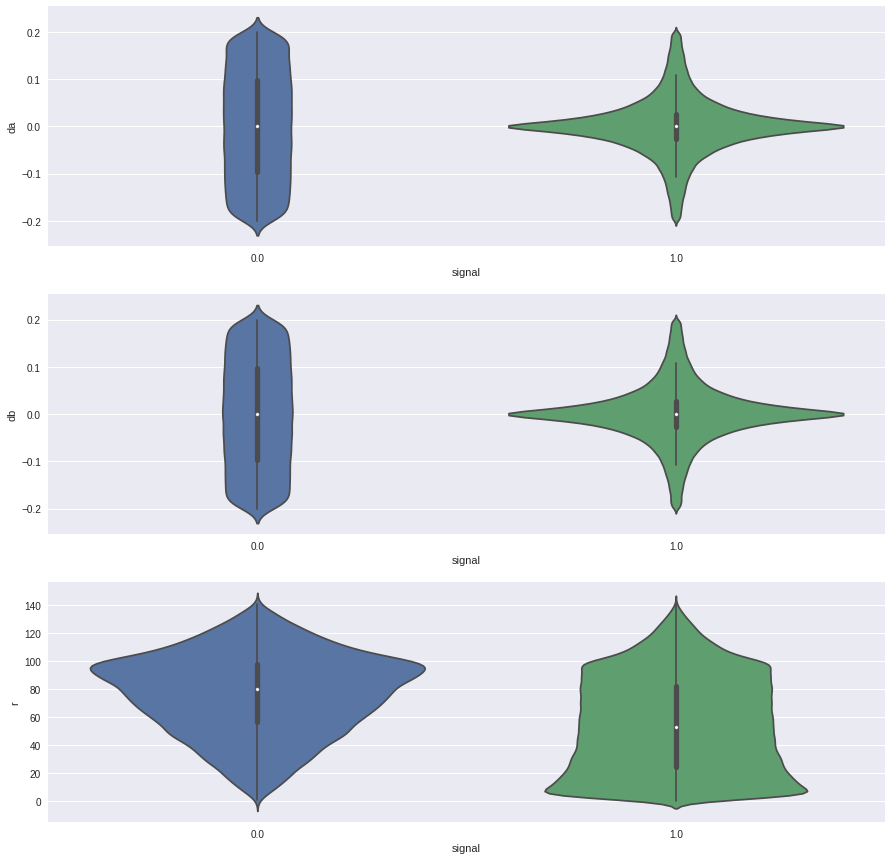

In [7]:
plt.figure(figsize=[15,15])
plt.subplot(311)
sns.violinplot(y="da", x = "signal", data=fdf, split=True);

plt.subplot(312)
sns.violinplot(y="db", x = "signal", data=fdf, split=True);

plt.subplot(313)
sns.violinplot(y="r", x = "signal", data=fdf, split=True);

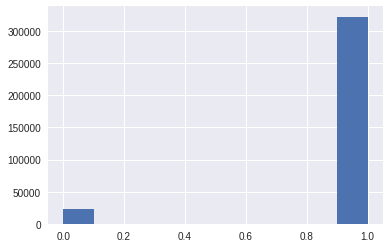

In [8]:
fdf.signal.hist()

In [9]:
fdf.head()

,X,Y,TX,TY,signal,r,da,db,parent
index,,,,,,,,,
892028.0,65944.695312,66873.703125,0.372805,-0.018341,0.0,127.594544,-0.076972,-0.194308,3367701.0
774883.0,30086.503906,56736.628906,-0.327097,0.077269,0.0,94.477411,0.090072,-0.005022,9314219.0
2741636.0,54708.191406,47517.656250,-0.234412,0.192783,0.0,93.918329,-0.003832,-0.068173,129033.0
5107504.0,36029.890625,37156.414062,-0.024786,0.337202,0.0,46.648367,0.117150,0.098270,4425962.0
9250117.0,66673.132812,41541.593750,0.182478,-0.260138,0.0,11.381803,0.015811,0.188095,7066409.0


In [10]:
#from sklearn.svm import SVC
#clf = SVC(probability=True)

In [11]:
#clf.fit(fdf.loc[:,['X','Y','TX','TY','r','da','db']], fdf.signal)

Что можно сделать:
- ввести фиксированную ошибку по углам, а уже из неё определять площадь ошибки

In [18]:
from sklearn.tree import DecisionTreeClassifier
clf = DecisionTreeClassifier(random_state=0)

In [29]:
X = fdf.loc[:,['X','Y','TX','TY','r','da','db']]
Y = fdf.signal
#clf.fit()

In [21]:
res = clf.predict(fdf.loc[:,['X','Y','TX','TY','r','da','db']])

In [23]:
clf.score(fdf.loc[:,['X','Y','TX','TY','r','da','db']],fdf.signal)

1.0

In [25]:
pr = clf.predict_proba(fdf.loc[:,['X','Y','TX','TY','r','da','db']])

([array([ 322278.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,       0.,   22918.]),
  array([  22918.,       0.,       0.,       0.,       0.,       0.,
               0.,       0.,       0.,  322278.])],
 array([ 0. ,  0.1,  0.2,  0.3,  0.4,  0.5,  0.6,  0.7,  0.8,  0.9,  1. ]),
 <a list of 2 Lists of Patches objects>)

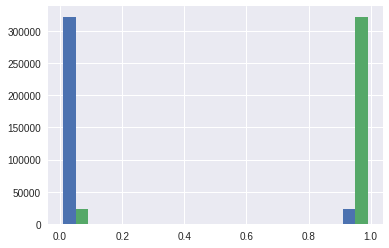

In [27]:
plt.hist(pr)

In [34]:
from sklearn.naive_bayes import GaussianNB
clf = GaussianNB()

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.svm import SVC
clf = SVC(kernel='linear', C=1)
scores = cross_val_score(clf, X, Y, cv=5)

In [ ]:
scores